# Affect of various features on Heating and Cooling loads in a building

This notebook was created to complete the project requirements of DSE200x
at UCSDx through EDx <br><br>
Original dataset [here](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency#)
<br><br>Dataset created by Angeliki Xifara (angxifara '@' gmail.com, Civil/Structural Engineer) and was processed by Athanasios Tsanas (tsanasthanasis '@' gmail.com, Oxford Centre for Industrial and Applied Mathematics, University of Oxford, UK).
<br><br> All code, analysis, and figures are original work by Chris May [(Github)](https://github.com/pezLyfe) unless otherwise noted
<br><br>
## Description of Dataset by the sources: 
We perform energy analysis using 12 different building shapes simulated in Ecotect. The buildings differ with respect to the glazing area, the glazing area distribution, and the orientation, amongst other parameters. We simulate various settings as functions of the afore-mentioned characteristics to obtain 768 building shapes. The dataset comprises 768 samples and 8 features, aiming to predict two real valued responses. It can also be used as a multi-class classification problem if the response is rounded to the nearest integer.

### Explanation of the Variables within the dataset:
The variable names in the data dictionary were somewhat unclear. A dive into the associated academic paper gave better results. The paper is reference in the citations section, but for convenience the variable meanings are given below.
<br>
    
Relative compactness | Surface area | Wall area | Roof area | Overall height 
:---: | :---: | :---: | :---: |:---: 
Surface area/volume | m<sup>2</sup> | m<sup>2</sup> | m<sup>2</sup> | m

Value | 1 | 2 | 3 | 4 
:---: | :---: | :---: | :---: |:---: 
Direction | North | South | East | West

Value | 0 | .10 | .25 | .40 
:---: | :---: | :---: | :---: |:---: 
Glazing % of floor area | 0 | 10% | 25% | 40%

Value | 0 | 1 | 2 | 3 | 4 
:---: | :---: | :---: | :---: |:---: | :---:
Glazing area distribution | None | Uniform | North bias | East bias | South bias | West bia

Heating Load | Cooling Load
:---: | :---: 
kWh/m<sup>2</sup> | kWh/m<sup>2</sup>

All buildings have the same volume, with different surface areas and individual dimensions. The materials of construction for the walls, floors, roof, and windows were modeled as being the same, and as such have the same insulating values. 

In [186]:
import numpy as np
import pandas as pd 
import sklearn as skl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

df = pd.read_csv('/Users/chrismay/Desktop/UCSDx/PythonDS/finalProject/energyEfficiencyData.csv')
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


# Data cleaning 
<br> This data was generated by an analysis program, and the column headers are labeled based on math conventions. Let's change that to something we all can understand. Luckily the data dictionary provided with the set gave us the column names. Let's rename the columns to something we can understand

In [187]:
df.columns = ['RelCompactness', 'Surface Area', 'Wall Area', 'Roof Area','Overall Height', \
             'Orientation', 'Glazing Area','Glazing Area Distro', 'HeatLoad', 'CoolLoad']
df.head()

,RelCompactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distro,HeatLoad,CoolLoad
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [188]:
df.shape #let's see how big this dataset is

(768, 10)

First let's comb through and see if there are any missing values in the dataset

In [189]:
missing = pd.isnull(df) #Returns a dataframe of boolean values. If a null value is present, returns True, else False
notMissing = ~missing #Create a new dataframe that's the inverse of the missing values (data present = True)
df = df[notMissing] #Filter based on the inverse boolean dataframe. The new dataframe will only contain rows with values
df.shape #Check the shape of the new dataframe to see if anything got dropped


(768, 10)

It looks like there were no entries missing. Now let's check and make sure all the entries are the type we want them to be

In [190]:
df.dtypes #Returns a list of each column and their corresponding data type

RelCompactness         float64
Surface Area           float64
Wall Area              float64
Roof Area              float64
Overall Height         float64
Orientation              int64
Glazing Area           float64
Glazing Area Distro      int64
HeatLoad               float64
CoolLoad               float64
dtype: object

All of the features were imported as either floats or ints. While that seems correct, a few of the features are actuall categorical variables. 
<br><br> Orientation and glazing area distribution are actually categorical variables, representing a few different model set-ups.
<br><br>ScikitLearn has a pre-processing package that easily does one-hot encoding, so let's take advantage of that here.

In [191]:
df = df.astype({'Orientation': 'category'}, copy=False, errors='raise') #Start by changing the datatype to be categories
df = df.astype({'Glazing Area Distro': 'category'}, copy = False, errors = 'raise')
#df = df.astype({'Overall Height': 'category'}, copy = False, erros = 'raise')
df.dtypes

RelCompactness          float64
Surface Area            float64
Wall Area               float64
Roof Area               float64
Overall Height          float64
Orientation            category
Glazing Area            float64
Glazing Area Distro    category
HeatLoad                float64
CoolLoad                float64
dtype: object

Notice I changed the overall height to be a categorical variable as well. In this study, we're essentially looking at only two examples of height: a one story building or a two story building. Building height is a discrete variable rather than continuous, so it makes more sense to make it a category
<br><br>

# Data exploration

In [192]:
df.describe()

,RelCompactness,Surface Area,Wall Area,Roof Area,Overall Height,Glazing Area,HeatLoad,CoolLoad
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,0.234375,22.307201,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,0.133221,10.090196,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,0.000000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,0.100000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,0.250000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,0.400000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,0.400000,43.100000,48.030000


Each row in this dataset represents a unique combination of features that were used as inputs to model the heating and cooling loads in a building simulation. So we can create a couple of scatter plots to get an idea of how the heating and cooling loads vary across different features.
<br><br>First, let's take a look and see how heating loads and cooling loads vary in each entry 

Text(0.5,1,'Heating Loads vs. Cooling Loads')

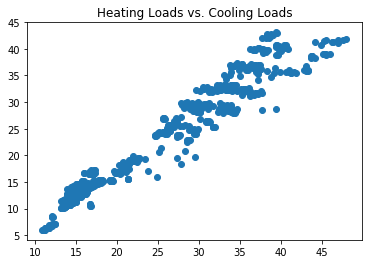

In [193]:
y = df['HeatLoad']
x = df['CoolLoad']
plt.scatter(x, y)
plt.title('Heating Loads vs. Cooling Loads')

As expected, buildings with a high heating load also have a high cooling load. 
<br>There seems to be a bit of an assymetry when the loads are at the higher end. In the 35 to 45 range on cooling loads, there seems to be a relatively higher heating load. 
<br><br>I'll have to remember to look at that deeper when we do our analysis. next let's see how relative compactness affects each

Text(0.5,1,'Cooling vs. Rel Compactness')

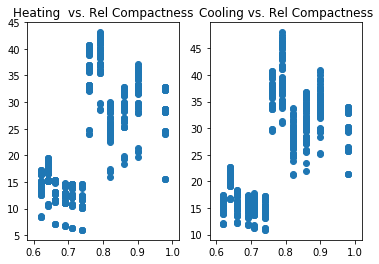

In [194]:
hy = df['HeatLoad']
hx = df['RelCompactness']
cy = df['CoolLoad']
cx = df['RelCompactness']

plt.subplot(1, 2, 1)
plt.scatter(hx, hy)
plt.title('Heating  vs. Rel Compactness')

plt.subplot(1, 2, 2)
plt.scatter(cx, cy)
plt.title('Cooling vs. Rel Compactness')

Ok, the buildings are generally more energy efficient on low relative compactness values, but things get weird above 0.75. There must be other factors that affect the target variables

Text(0.5,1,'Cooling vs. Surf Area')

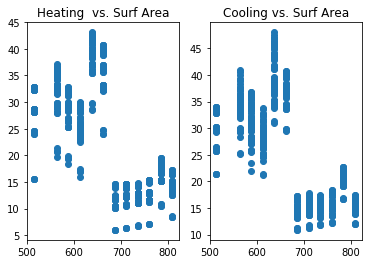

In [195]:
hy = df['HeatLoad']
hx = df['Surface Area']
cy = df['CoolLoad']
cx = df['Surface Area']

plt.subplot(1, 2, 1)
plt.scatter(hx, hy)
plt.title('Heating  vs. Surf Area')

plt.subplot(1, 2, 2)
plt.scatter(cx, cy)
plt.title('Cooling vs. Surf Area')

There's a big difference between the smaller surface area values and the larger surface areas. Interesting to note, there must be something in the geometries above a certain number

**To confirm, the highest surface area buildings must also be the shortest buildings** 

Text(0.5,1,'Cooling vs. Wall Area')

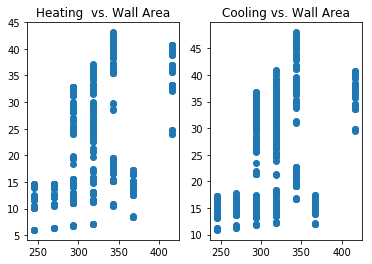

In [196]:
hy = df['HeatLoad']
hx = df['Wall Area']
cy = df['CoolLoad']
cx = df['Wall Area']

plt.subplot(1, 2, 1)
plt.scatter(hx, hy)
plt.title('Heating  vs. Wall Area')

plt.subplot(1, 2, 2)
plt.scatter(cx, cy)
plt.title('Cooling vs. Wall Area')

I'm a markdown cell

Text(0.5,1,'Cooling vs. Roof Area')

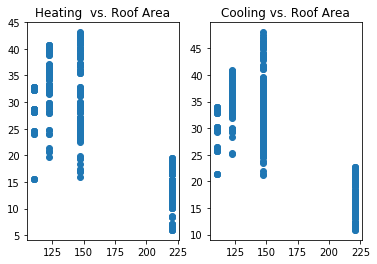

In [197]:
hy = df['HeatLoad']
hx = df['Roof Area']
cy = df['CoolLoad']
cx = df['Roof Area']

plt.subplot(1, 2, 1)
plt.scatter(hx, hy)
plt.title('Heating  vs. Roof Area')

plt.subplot(1, 2, 2)
plt.scatter(cx, cy)
plt.title('Cooling vs. Roof Area')

The really big roof areas are probably due to the buildings being low and squat

Text(0.5,1,'Cooling vs. Height')

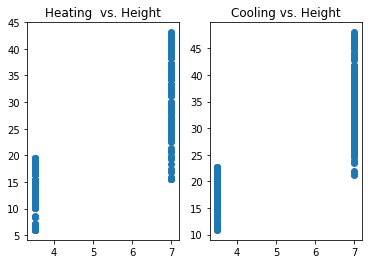

In [198]:
hy = df['HeatLoad']
hx = df['Overall Height']
cy = df['CoolLoad']
cx = df['Overall Height']

plt.subplot(1, 2, 1)
plt.scatter(hx, hy)
plt.title('Heating  vs. Height')

plt.subplot(1, 2, 2)
plt.scatter(cx, cy)
plt.title('Cooling vs. Height')

Text(0.5,1,'Cooling vs. Orientation')

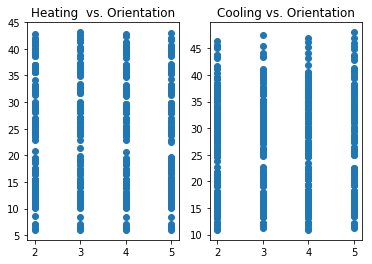

In [199]:
hy = df['HeatLoad']
hx = df['Orientation']
cy = df['CoolLoad']
cx = df['Orientation']

plt.subplot(1, 2, 1)
plt.scatter(hx, hy)
plt.title('Heating  vs. Orientation')

plt.subplot(1, 2, 2)
plt.scatter(cx, cy)
plt.title('Cooling vs. Orientation')

Text(0.5,1,'Cooling vs. Glaze Area')

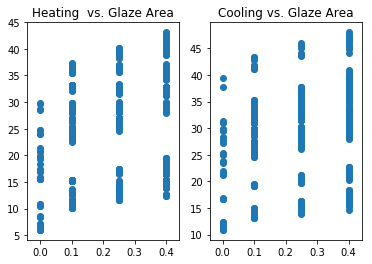

In [200]:
hy = df['HeatLoad']
hx = df['Glazing Area']
cy = df['CoolLoad']
cx = df['Glazing Area']

plt.subplot(1, 2, 1)
plt.scatter(hx, hy)
plt.title('Heating  vs. Glaze Area')

plt.subplot(1, 2, 2)
plt.scatter(cx, cy)
plt.title('Cooling vs. Glaze Area')

Text(0.5,1,'Cooling vs. Glaze Distro')

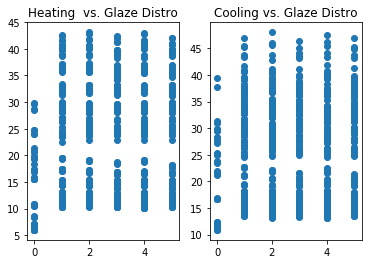

In [201]:
hy = df['HeatLoad']
hx = df['Glazing Area Distro']
cy = df['CoolLoad']
cx = df['Glazing Area Distro']

plt.subplot(1, 2, 1)
plt.scatter(hx, hy)
plt.title('Heating  vs. Glaze Distro')

plt.subplot(1, 2, 2)
plt.scatter(cx, cy)
plt.title('Cooling vs. Glaze Distro')

One things that's been definitely  clear is that overall height has an outsize affect on the heating and cooling loads. That's not a super helpful start though. In the dataset provided, there's only two measurements provided, and they're vastly different. Let's hold overall height constant and take a look at the distributions again

In [202]:
shortDFMask =  df['Overall Height'] == 3.5 #Returns a dataframe of boolean values, where True = rows w/height of 3.5
tallDFMask = ~shortDFMask #Create a new dataframe that's the inverse of the missing values (height of 7 = True)
shortDF = df[shortDFMask] #Filter based on the inverse boolean dataframe
tallDF = df[tallDFMask]

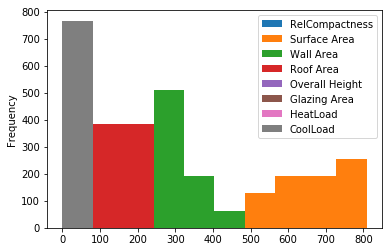

In [203]:
df.plot.hist()

(array([ 7.,  2., 11., 31., 19., 21., 52., 21., 33., 54., 18., 35., 22.,
        19., 12.,  2.,  9.,  6.,  6.,  4.]),
 array([21.16  , 22.5035, 23.847 , 25.1905, 26.534 , 27.8775, 29.221 ,
        30.5645, 31.908 , 33.2515, 34.595 , 35.9385, 37.282 , 38.6255,
        39.969 , 41.3125, 42.656 , 43.9995, 45.343 , 46.6865, 48.03  ]),
 <a list of 20 Patch objects>)

/Users/chrismay/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


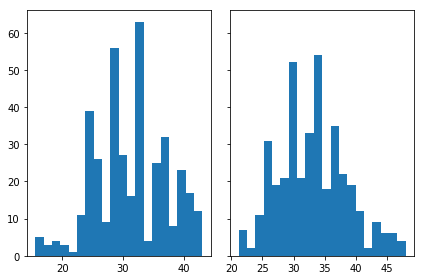

In [204]:
nBins = 20

x = tallDF['HeatLoad']
y = tallDF['CoolLoad']

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(x, bins=nBins)
axs[1].hist(y, bins=nBins)

In [210]:
df['low_efficiency'] = (df['HeatLoad'] > 20 )*1
y = df[['low_efficiency']].copy()

In [243]:
learning_features = ['Orientation', 'Glazing Area', 'Glazing Area Distro', 'Overall Height', 'RelCompactness']
X = df[learning_features].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [244]:
energy_classifier = DecisionTreeClassifier(max_leaf_nodes=15, random_state=0)
energy_classifier.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=15,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [245]:
predictions = energy_classifier.predict(X_test)
accuracy_score(y_true = y_test, y_pred = predictions)

1.0

In [240]:
shortDFMask =  df['Overall Height'] == 3.5 #Returns a dataframe of boolean values, where True = rows w/height of 3.5
tallDFMask = ~shortDFMask #Create a new dataframe that's the inverse of the missing values (height of 7 = True)
shortDF = df[shortDFMask].copy() #Filter based on the inverse boolean dataframe
tallDF = df[tallDFMask].copy()

tallMean = tallDF['HeatLoad'].median() #Grab the median energy efficiency values for tall buildings
shortMean = shortDF['HeatLoad'].median() #Grab the median energy efficiency values for short buildings

tallDF.drop('low_efficiency', axis = 1, inplace = True) #Drop the column with the old efficiency values
shortDF.drop('low_efficiency', axis = 1, inplace = True) #And do the same for the short buildings

tallDF['low_efficiency'] = (tallDF['HeatLoad'] > tallMean )*1 #Create new classifications for tall and short
shortDF['low_efficiency'] = (shortDF['HeatLoad'] > shortMean) * 1

In [241]:
tall_Learning_Features = ['Orientation', 'Glazing Area', 'Glazing Area Distro', 'RelCompactness']
tallX = tallDF[tall_Learning_Features].copy() #Select the features to be used in the classification tree
tallY = tallDF[['low_efficiency']].copy() #The target variable

#Split the data set into a training set and a testing set
tallX_train, tallX_test, tallY_train, tallY_test = train_test_split(tallX, tallY, test_size=0.33, random_state=0)

tall_energy_classifier = DecisionTreeClassifier(max_leaf_nodes=10, random_state=0)#Set parameters for the tree
tall_energy_classifier.fit(tallX_train, tallY_train) #Train the model

predictions = tall_energy_classifier.predict(tallX_test) #Run predictions on the test set
accuracy_score(y_true = tallY_test, y_pred = predictions) #Calculate an accuracy score for the prediction

0.9606299212598425

In [242]:
short_Learning_Features = ['Orientation', 'Glazing Area', 'Glazing Area Distro', 'RelCompactness']
shortX = shortDF[tall_Learning_Features].copy()
shortY = shortDF[['low_efficiency']].copy()

shortX_train, shortX_test, shortY_train, shortY_test = train_test_split(shortX, shortY, test_size=0.33, random_state=0)
short_energy_classifier = DecisionTreeClassifier(max_leaf_nodes=10, random_state=0)
short_energy_classifier.fit(shortX_train, shortY_train)

predictions = short_energy_classifier.predict(tallX_test)
accuracy_score(y_true = shortY_test, y_pred = predictions)

0.8188976377952756